In [1]:
import matplotlib.pyplot as plt
import numpy as np
import suite2p
from scipy.signal import find_peaks, butter, filtfilt
from scipy.ndimage import percentile_filter

import scipy.fftpack

In [2]:
raw = "C:\\Users\\zfj\\data\\092822B - bleed testing\\chirp_bleed_00001.tif"
tif = suite2p.io.tiff.ScanImageTiffReader(raw)

raw_dat = tif.data().reshape((-1,4,32,128))
sf = (32*128*32.79)

Exception: No strip offsets found.  This reader only reads Tiffs with strip data

In [324]:
#detect frame transitions using an edge filter
frame = raw_dat[:,3,:,:].flatten()
# frame = np.diff(raw_dat[:,3,:,:].flatten())

flen = 500 #should be less than the frame period; greater than some threshold based on noise level and bouncing time
tmp = np.convolve(frame-2048, np.concatenate((np.ones(flen),-np.ones(flen)))/(flen*2), mode='same')

frame_t = find_peaks(np.abs(tmp), height=1024, distance=sf/70)[0] #debounce while allowing for some variation in frame timing 
start_t = find_peaks(tmp, height=4096, distance=sf/61)[0] #transitions corresponding to trial start

f_int = np.diff(frame_t)


(945542, 1218634)


(7.040110778343245, 9.07344411167658)

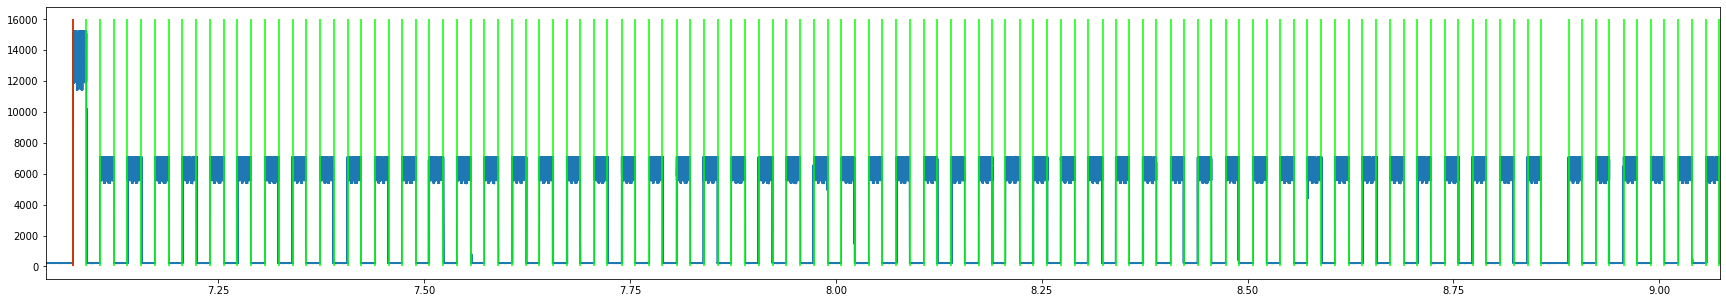

In [327]:
#plot detections from the first 2 seconds of the first trial
xlim = (int(start_t[0]-sf/30), int(start_t[0]+2*sf))
t = np.linspace(0,(len(frame)-1)/sf, len(frame))

plt.figure(figsize=(30,5))
plt.plot(t[xlim[0]:xlim[1]],frame[xlim[0]:xlim[1]])
plt.vlines((frame_t[:120])/sf, 0, 16000, color=[0,1,0])
plt.vlines((start_t[0])/sf, 0, 16000, color=[1,0,0])

plt.xlim(start_t[0]/sf-(1/30), start_t[0]/sf+2)

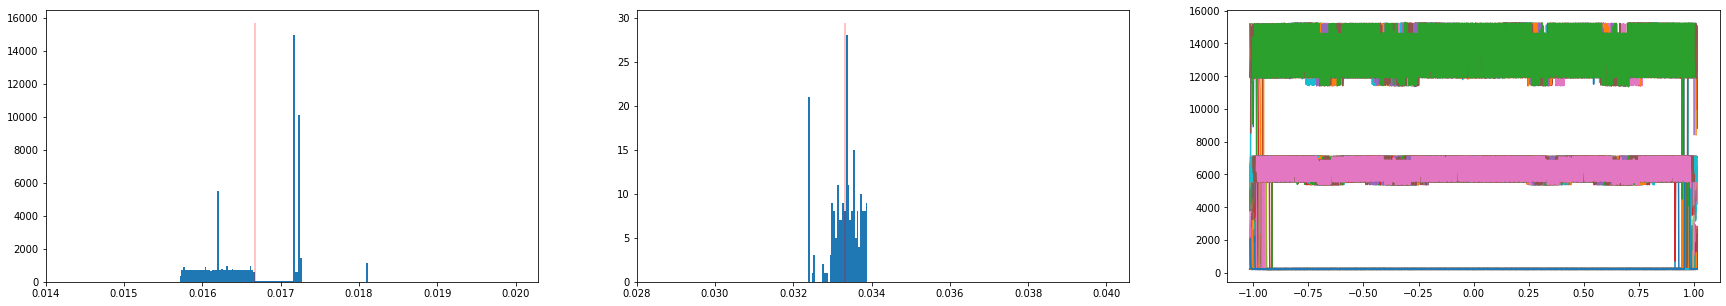

0.003325925358265001


In [328]:
fig,ax = plt.subplots(1,3, figsize=(30,5))
#plot the distribution of correct frame intervals
ax[0].hist(f_int/sf, bins=np.linspace(1/70,1/50,250)) 
ax[0].vlines(1/60, 0, ax[0].get_ylim()[1], color='r', alpha=.3)



#plot the distribution of dropped frame intervals
ax[1].hist(f_int/sf, bins=np.linspace(1/35,1/25,250)) 
ax[1].vlines(1/30, 0, ax[1].get_ylim()[1], color='r', alpha=.3)

#plot the dropped frame timings. Any transitions around 0 denote detection failure
i = np.where(np.logical_and(f_int>sf/50, f_int<sf/25))[0]+1
for ii in i:
    x = np.arange(frame_t[ii-1],frame_t[ii]) - (frame_t[ii-1]+frame_t[ii])/2
    ax[2].plot(x/sf*60, frame[frame_t[ii-1] : frame_t[ii]])
plt.show()

#print the fraction of frames which are dropped
print(np.count_nonzero(np.logical_and(f_int>sf/35, f_int<sf/25)) / np.count_nonzero(f_int<sf/25))


In [384]:
#for this analysis, we can just average the values within a frame

g = raw_dat[:,0,:,:].flatten()
bleed = np.empty(f_int.shape)
for i in range(len(bleed)):
    bleed[i] = g[frame_t[i] : frame_t[i+1]].mean()



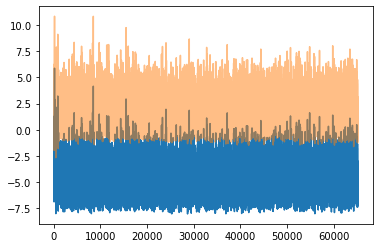

In [385]:
plt.plot(bleed)
plt.plot(bleed - percentile_filter(bleed,8,1000,mode='nearest'), alpha=.5)

In [331]:
def chirp(sf):
   return np.concatenate((
        np.zeros(2*sf), #pre time
        np.ones(3*sf), #positive step
        np.zeros(3*sf), #negative time
        np.ones(2*sf) * 0.5, #inter time
        
        -np.sin(2*np.pi*np.linspace(0,8/sf,sf*8).cumsum() + np.pi)/2 + .5, # freq chirp
        np.ones(2*sf) * 0.5, #inter time
        -np.linspace(0,1,sf*8)*np.sin(2*np.pi*2*np.arange(0, 8, 1/sf) + np.pi)/2 + .5, # amp chirp

        np.ones(2*sf) * 0.5, #inter time
        np.zeros(2*sf), #tail time
   )) 

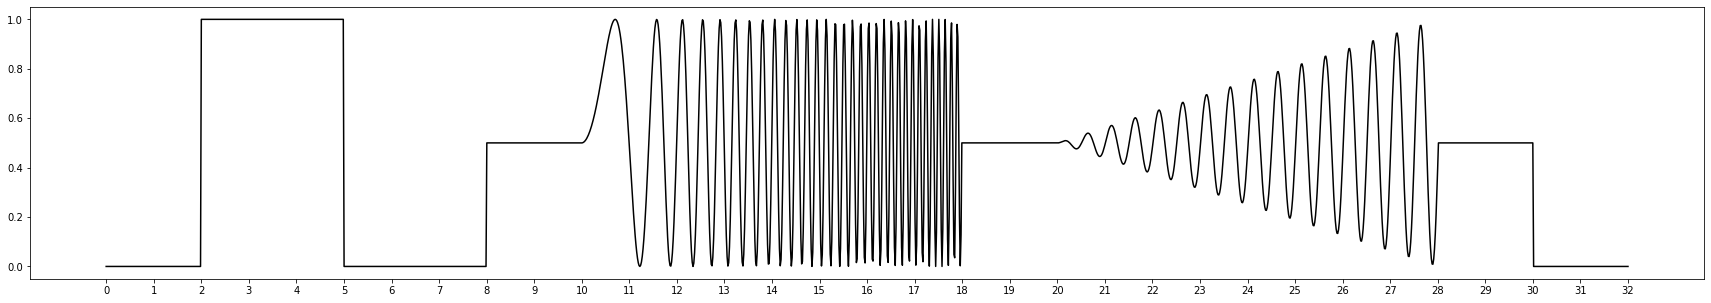

In [362]:
d = chirp(60)
plt.figure(figsize=(30,5))
plt.plot(np.linspace(0,32,d.shape[0]), d, color='k')
plt.xticks(np.arange(33))
plt.show()

In [386]:
last_trigger = 0
cnt=-1

regr = np.zeros(f_int.shape)
img = np.empty((len(d), len(start_t)))
for i in range(len(regr)):
    if frame_t[i] in start_t:
        last_trigger = i
        cnt+=1
    
    if i - last_trigger < len(d):
        regr[i] = d[i - last_trigger]
        img[i - last_trigger, cnt] = bleed[i]



[[1.         0.54282371]
 [0.54282371 1.        ]]
[[1.        0.5517225]
 [0.5517225 1.       ]]


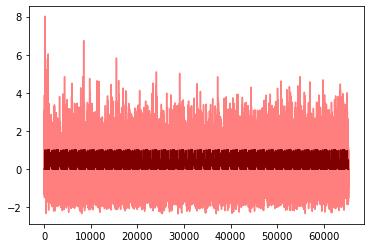

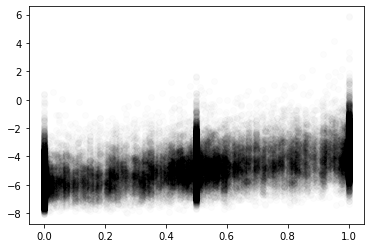

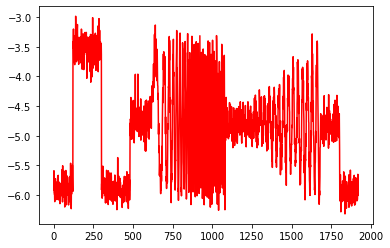

In [387]:
plt.plot(regr,color='k')
plt.plot((bleed - bleed.mean())/bleed.std(),color=[1,0,0], alpha=.5)

plt.figure()
plt.scatter(regr, bleed, color = 'k', alpha=.01)
print(np.corrcoef(regr,bleed - percentile_filter(bleed,8,1000,mode='nearest')))
print(np.corrcoef(regr,bleed))

plt.figure()
plt.plot(img.mean(axis=1), color=[1,0,0])

In [369]:
t = np.zeros(raw_dat[:,0,:,:].flatten().shape)

for i in range(len(f_int)):
    if frame_t[i] in start_t:
        last_trigger = i

    if i - last_trigger < len(d):
        t[frame_t[i]:frame_t[i+1]] = d[i - last_trigger]


In [388]:
# print(t.shape, g.shape)
print(np.corrcoef(t,g))

# print((g**2).mean()

32*60*.003


[[1.         0.01581054]
 [0.01581054 1.        ]]


5.76